In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

In [2]:
# Carregar datasets
dataset = pd.read_csv('dataset.csv')
features = pd.read_csv('just_features.csv')

In [3]:
# Função para tratamento de outliers usando IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [4]:
# Remover outliers na variável 'custo' e 'imc'
dataset = remove_outliers(dataset, 'custo')
dataset = remove_outliers(dataset, 'imc')

In [5]:
# Separar features e target
X = dataset.drop(columns=['custo'])
y = dataset['custo']

In [6]:
# Identificar colunas categóricas e numéricas
categorical_features = ['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']
numerical_features = ['imc']

In [7]:
# Configurar transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [8]:
# Criar o preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Pipeline para XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

In [11]:
# Configurar GridSearch para XGBoost
param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1],
    'regressor__colsample_bytree': [0.8, 1]
}

In [12]:
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='r2', verbose=2)


In [13]:
# Treinar XGBoost com GridSearch
print("Treinando XGBoost com ajuste fino...")
grid_search_xgb.fit(X_train, y_train)

Treinando XGBoost com ajuste fino...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__subsample=0.8; total time=   0.0s
[CV] END regressor__colsample_bytree=0.8, reg

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['imc']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['genero',
                                                                          'estado_civil',
                                                                          'zona_residencia',
                                                                          'fumador',
                                                                          'class_etaria'])])),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_byn...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__colsample_bytree': [0.8, 1],
                         'regressor__learning_rate': [0.01, 0.05, 0.1],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [100, 200, 300],
                         'regressor__subsample': [0.8, 1]},
             scoring='r2', verbose=2)

In [14]:
# Melhor modelo XGBoost
best_xgb = grid_search_xgb.best_estimator_
print(f"Melhores hiperparâmetros XGBoost: {grid_search_xgb.best_params_}")

Melhores hiperparâmetros XGBoost: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}


In [15]:
# Avaliação do modelo XGBoost
y_pred_xgb = best_xgb.predict(X_test)
score_xgb = r2_score(y_test, y_pred_xgb)
print(f"R² Score com XGBoost: {score_xgb:.4f}")

R² Score com XGBoost: 0.6615


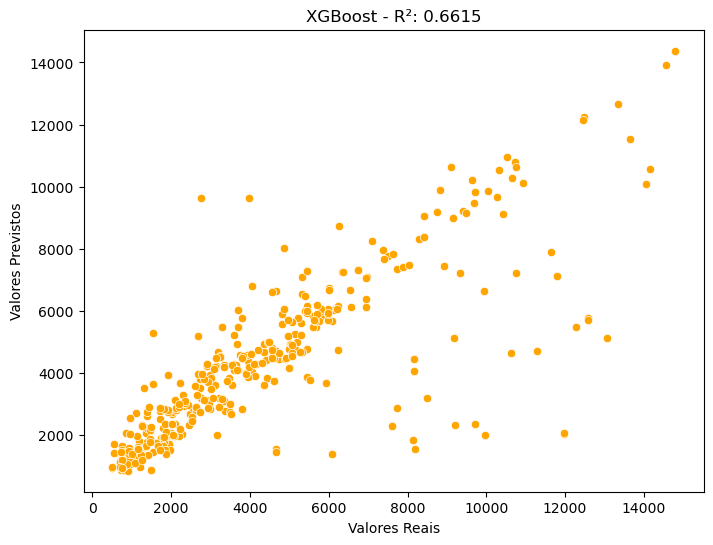

In [16]:
# Comparação gráfica entre valores reais e previstos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, color='orange')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title(f"XGBoost - R²: {score_xgb:.4f}")
plt.show()

In [17]:
# Prever os custos para novos dados (just_features.csv)
predictions = best_xgb.predict(features)
predictions_df = pd.DataFrame(predictions, columns=['custo'])
predictions_df.to_csv('grupo#_custos_estimados.csv', index=False)
print("Predições salvas no arquivo 'grupo#_custos_estimados.csv'")

Predições salvas no arquivo 'grupo#_custos_estimados.csv'
